   popularity     length  elevation_gain  difficulty_rating  num_reviews  \
0     24.8931  15610.598       1161.8976                  5          423   
1     18.0311   6920.162        507.7968                  3          260   
2     17.7821   2896.812         81.9912                  1          224   
3     16.2674   3379.614        119.7864                  1          237   
4     12.5935  29772.790       1124.7120                  5          110   

   state_name_Arizona  state_name_Arkansas  state_name_California  \
0               False                False                  False   
1               False                False                  False   
2               False                False                  False   
3               False                False                  False   
4               False                False                  False   

   state_name_Colorado  state_name_Florida  ...  activities__snowboarding  \
0                False               False  ...    

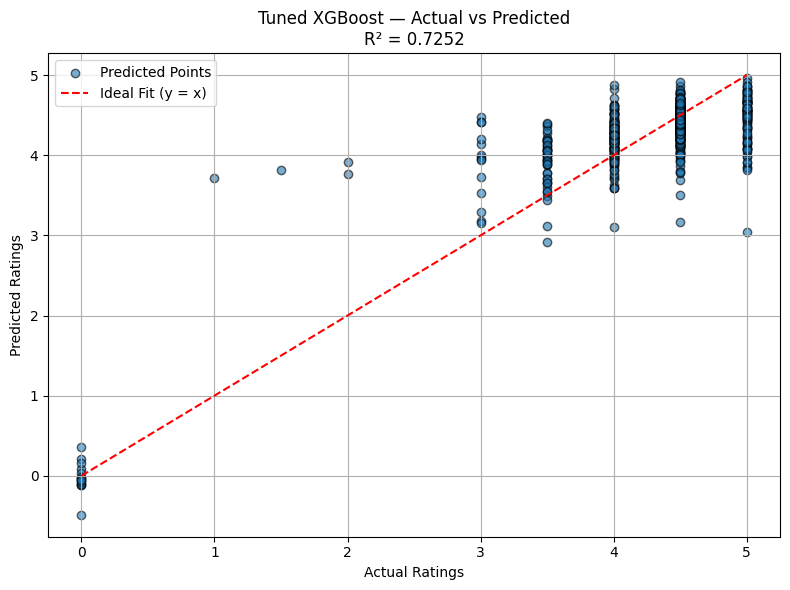

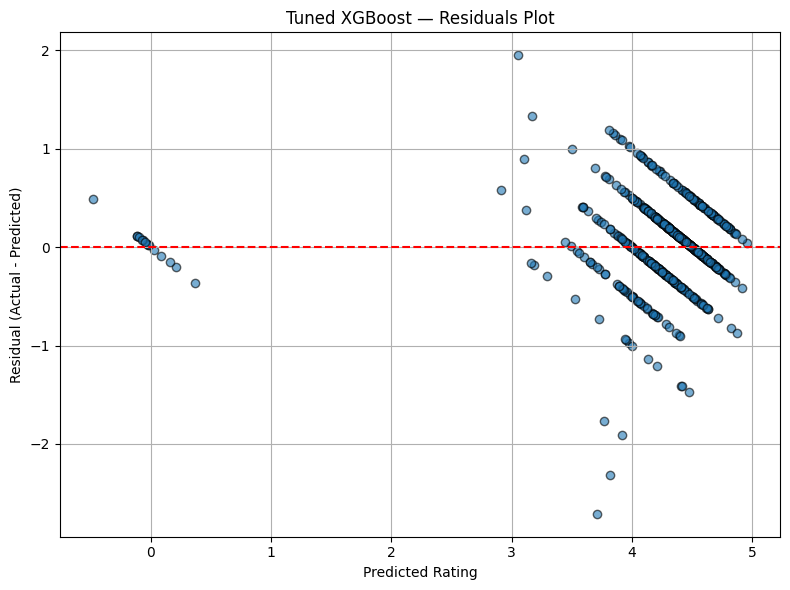

In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import randint, uniform


def load_and_clean_data(filepath):

    df = pd.read_csv(filepath)

    columns_to_drop = ['trail_id', 'features', 'activities', 'name', 'city_name', 'area_name', 'country_name', '_geoloc', 'visitor_usage', 'avg_rating', 'units']
    #one-hot encoding cat columns
    categorical_columns = ['state_name', 'route_type']
    df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
    
    # Handle list-based columns: features and activities
    for col in ['features', 'activities']:
        df[f'{col}_list'] = df[col].dropna().apply(ast.literal_eval)
        df[f'{col}_list'] = df[f'{col}_list'].apply(lambda x: x if isinstance(x, list) else [])
        mlb = MultiLabelBinarizer()
        encoded = pd.DataFrame(mlb.fit_transform(df[f'{col}_list']), columns=[f'{col}__{v}' for v in mlb.classes_], index=df.index)
        df_encoded = pd.concat([df_encoded, encoded], axis=1)
        try:
            df_encoded = df_encoded.drop(columns=[col, f'{col}_list'], inplace=True)
        except:
            continue
            
    # Log transform to help skewed columns
    for col in ['length', 'elevation_gain', 'popularity', 'num_reviews']:
        df_encoded[f'log_{col}'] = np.log1p(df_encoded[col])

    y = df['avg_rating']
    X = df_encoded.drop(columns=columns_to_drop)

    return X, y

def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n\U0001F50D {name} Evaluation:")
    print(f" - RMSE: {rmse:.4f}")
    print(f" - R² Score: {r2:.4f}")

def plot_actual_vs_predicted(y_true, y_pred, model_name='Model'):
    r2 = r2_score(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, edgecolors='k', label='Predicted Points')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal Fit (y = x)')
    plt.xlabel("Actual Ratings")
    plt.ylabel("Predicted Ratings")
    plt.title(f"{model_name} — Actual vs Predicted\nR² = {r2:.4f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("Data/r2_scatter_plot.png", dpi=300)
    plt.show()

def plot_residuals(y_true, y_pred, model_name='Model'):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
    plt.xlabel("Predicted Rating")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title(f"{model_name} — Residuals Plot")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("Data/residuals_plot.png", dpi=300)
    plt.show()

def main():
    X, y = load_and_clean_data("Data/alltrails-data.csv")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # XGBoost tuning
    param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': [3, 5, 7, 10],
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'gamma': [0, 1, 5]
    }

    xgb = XGBRegressor(random_state=42)
    search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=30, scoring='r2', cv=5, random_state=42, n_jobs=-1, verbose=1)
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)

    evaluate_model("Tuned XGBoost", y_test, y_pred)
    print("Best XGBoost params:")
    print(search.best_params_)

    plot_actual_vs_predicted(y_test, y_pred, model_name="Tuned XGBoost")
    plot_residuals(y_test, y_pred, model_name="Tuned XGBoost")

if __name__ == '__main__':
    main()
